<a href="https://colab.research.google.com/github/Rohitha2803/Eye_Disease_Classification/blob/main/eye_disease_classified_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

<a id="1"></a>
<div id="animated-container" style="position: relative;
            border-radius: 10px;
            padding: 10px;
            font-family: Arial, sans-serif;
            font-size: 36px;
            font-weight: 900;
            color: black;
            display: inline-block;
            text-transform: uppercase;
            box-shadow: 2px 2px 4px #888;
            text-shadow: 2px 2px 4px #888;
            overflow: hidden;
            background-color: #800606 ;
            cursor: pointer;" onclick="toggleAnimation()"> <!-- Added cursor pointer and onclick event -->
    <div style="position: absolute;
                top: 50%;
                right: 0; /* Adjusted to place on the right side */
                transform: translateY(45%);">
        <!-- <img src="https://www.kaggle.com/static/images/tier-animation-transparent.gif" alt="Cartoon Character" style="height: 100px; width: auto;"> -->
    </div>
    <div style="font-weight: bold;"></div>
    <span style="font-style: italic; text-shadow: 2px 2px 4px #888; color: white;">Preprocessing 🛠️</span>
         <!-- <img src="https://pin.it/6mmgqwOvV" alt="Cartoon Character" style="height: 50px; width: auto;"> -->
</div>

<script>
    function toggleAnimation() {
        var container = document.getElementById('animated-container');
        var animationDiv = container.querySelector('div');
        if (animationDiv.style.animationPlayState === 'paused') {
            animationDiv.style.animationPlayState = 'running';
        } else {
            animationDiv.style.animationPlayState = 'paused';
        }
    }
</script>


In [ ]:

rescale = tf.keras.layers.Rescaling(1./255)

# Load train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/dataset',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='categorical',
)


train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Load validation dataset
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/dataset',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',  # Assuming you have multiple classes
)

# Preprocess validation dataset (rescale)
validation_ds = validation_ds.map(lambda x, y: (rescale(x), y))

# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/dataset',
    batch_size=32,
    image_size=(256, 256),
    label_mode='categorical',  # Assuming you have multiple classes
    shuffle=False,
)

# Preprocess test dataset (rescale)
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

Found 4277 files belonging to 4 classes.
Using 3422 files for training.
Found 4277 files belonging to 4 classes.
Using 855 files for validation.
Found 4277 files belonging to 4 classes.


## **Check Shape After Preprocessing**

In [ ]:
# Check the first image shape in the training dataset
print("Shape of the first image in the training dataset:", next(iter(train_ds))[0][0].shape)
# Check the first image shape in the validation dataset
print("Shape of the first image in the validation dataset:", next(iter(validation_ds))[0][0].shape)
# Check the first image shape in the test dataset
print("Shape of the first image in the test dataset:", next(iter(test_ds))[0][0].shape)

Shape of the first image in the training dataset: (256, 256, 3)
Shape of the first image in the validation dataset: (256, 256, 3)
Shape of the first image in the test dataset: (256, 256, 3)


## **Check Pixel Value After Preprocessing**

In [ ]:
# Initialize variables to store minimum and maximum pixel values
min_pixel_value = float('inf')
max_pixel_value = float('-inf')

# Iterate through the dataset
for images, _ in train_ds:
    # Compute the minimum and maximum pixel values in the current batch of images
    batch_min = tf.reduce_min(images)
    batch_max = tf.reduce_max(images)

    # Update overall minimum and maximum pixel values
    min_pixel_value = tf.minimum(min_pixel_value, batch_min)
    max_pixel_value = tf.maximum(max_pixel_value, batch_max)

# Print the minimum and maximum pixel values
print("Minimum pixel value:", min_pixel_value.numpy())
print("Maximum pixel value:", max_pixel_value.numpy())


Minimum pixel value: 0.0
Maximum pixel value: 1.0


<a id="1"></a>
<div id="animated-container" style="position: relative;
            border-radius: 10px;
            padding: 10px;
            font-family: Arial, sans-serif;
            font-size: 36px;
            font-weight: 900;
            color: black;
            display: inline-block;
            text-transform: uppercase;
            box-shadow: 2px 2px 4px #888;
            text-shadow: 2px 2px 4px #888;
            overflow: hidden;
            background-color: #800606 ;
            cursor: pointer;" onclick="toggleAnimation()"> <!-- Added cursor pointer and onclick event -->
    <div style="position: absolute;
                top: 50%;
                right: 0; /* Adjusted to place on the right side */
                transform: translateY(45%);">
        <!-- <img src="https://www.kaggle.com/static/images/tier-animation-transparent.gif" alt="Cartoon Character" style="height: 100px; width: auto;"> -->
    </div>
    <div style="font-weight: bold;"></div>
    <span style="font-style: italic; text-shadow: 2px 2px 4px #888; color: white;">Visualization 🕵</span>
         <!-- <img src="https://pin.it/6mmgqwOvV" alt="Cartoon Character" style="height: 50px; width: auto;"> -->
</div>

<script>
    function toggleAnimation() {
        var container = document.getElementById('animated-container');
        var animationDiv = container.querySelector('div');
        if (animationDiv.style.animationPlayState === 'paused') {
            animationDiv.style.animationPlayState = 'running';
        } else {
            animationDiv.style.animationPlayState = 'paused';
        }
    }
</script>


In [ ]:
def visualize_images(path, target_size=(256, 256), num_images=5):

    # Get a list of image filenames
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    # Select random images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, image_filename in enumerate(selected_images):
        # Load image and resize
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)

        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


<a id="1"></a>
<div id="animated-container" style="position: relative;
            border-radius: 10px;
            padding: 10px;
            font-family: Arial, sans-serif;
            font-size: 36px;
            font-weight: 900;
            color: black;
            display: inline-block;
            text-transform: uppercase;
            box-shadow: 2px 2px 4px #888;
            text-shadow: 2px 2px 4px #888;
            overflow: hidden;
            background-color: #800606 ;
            cursor: pointer;" onclick="toggleAnimation()"> <!-- Added cursor pointer and onclick event -->
    <div style="position: absolute;
                top: 50%;
                right: 0; /* Adjusted to place on the right side */
                transform: translateY(45%);">
        <!-- <img src="https://www.kaggle.com/static/images/tier-animation-transparent.gif" alt="Cartoon Character" style="height: 100px; width: auto;"> -->
    </div>
    <div style="font-weight: bold;"></div>
    <span style="font-style: italic; text-shadow: 2px 2px 4px #888; color: white;">Cataract 👁️‍🗨️</span>
         <!-- <img src="https://pin.it/6mmgqwOvV" alt="Cartoon Character" style="height: 50px; width: auto;"> -->
</div>

<script>
    function toggleAnimation() {
        var container = document.getElementById('animated-container');
        var animationDiv = container.querySelector('div');
        if (animationDiv.style.animationPlayState === 'paused') {
            animationDiv.style.animationPlayState = 'running';
        } else {
            animationDiv.style.animationPlayState = 'paused';
        }
    }
</script>


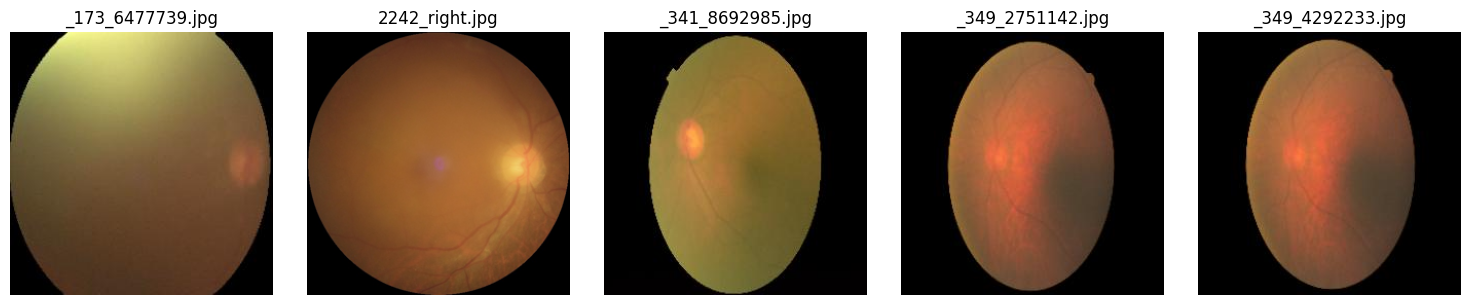

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/dataset/cataract"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

<a id="1"></a>
<div id="animated-container" style="position: relative;
            border-radius: 10px;
            padding: 10px;
            font-family: Arial, sans-serif;
            font-size: 36px;
            font-weight: 900;
            color: black;
            display: inline-block;
            text-transform: uppercase;
            box-shadow: 2px 2px 4px #888;
            text-shadow: 2px 2px 4px #888;
            overflow: hidden;
            background-color: #800606 ;
            cursor: pointer;" onclick="toggleAnimation()"> <!-- Added cursor pointer and onclick event -->
    <div style="position: absolute;
                top: 50%;
                right: 0; /* Adjusted to place on the right side */
                transform: translateY(45%);">
        <!-- <img src="https://www.kaggle.com/static/images/tier-animation-transparent.gif" alt="Cartoon Character" style="height: 100px; width: auto;"> -->
    </div>
    <div style="font-weight: bold;"></div>
    <span style="font-style: italic; text-shadow: 2px 2px 4px #888; color: white;">Diabetic-Retinopathy 🦠</span>
         <!-- <img src="https://pin.it/6mmgqwOvV" alt="Cartoon Character" style="height: 50px; width: auto;"> -->
</div>

<script>
    function toggleAnimation() {
        var container = document.getElementById('animated-container');
        var animationDiv = container.querySelector('div');
        if (animationDiv.style.animationPlayState === 'paused') {
            animationDiv.style.animationPlayState = 'running';
        } else {
            animationDiv.style.animationPlayState = 'paused';
        }
    }
</script>


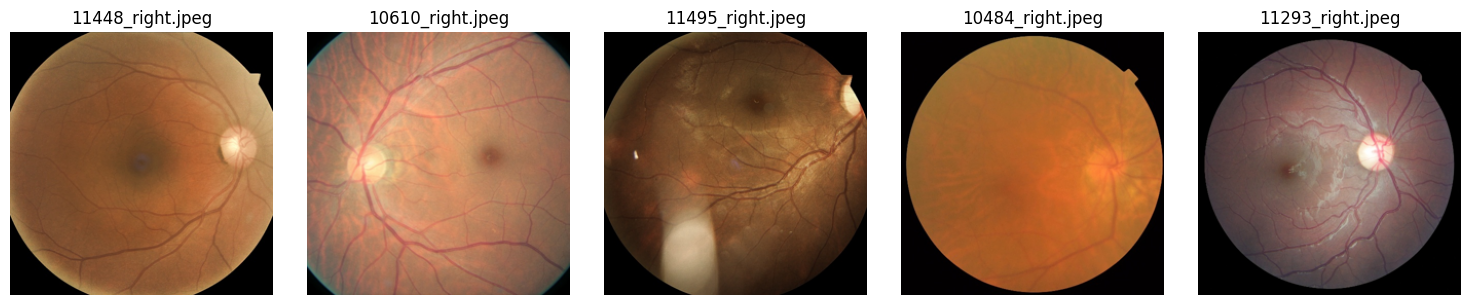

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/dataset/diabetic_retinopathy"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

<a id="1"></a>
<div id="animated-container" style="position: relative;
            border-radius: 10px;
            padding: 10px;
            font-family: Arial, sans-serif;
            font-size: 36px;
            font-weight: 900;
            color: black;
            display: inline-block;
            text-transform: uppercase;
            box-shadow: 2px 2px 4px #888;
            text-shadow: 2px 2px 4px #888;
            overflow: hidden;
            background-color: #800606 ;
            cursor: pointer;" onclick="toggleAnimation()"> <!-- Added cursor pointer and onclick event -->
    <div style="position: absolute;
                top: 50%;
                right: 0; /* Adjusted to place on the right side */
                transform: translateY(45%);">
        <!-- <img src="https://www.kaggle.com/static/images/tier-animation-transparent.gif" alt="Cartoon Character" style="height: 100px; width: auto;"> -->
    </div>
    <div style="font-weight: bold;"></div>
    <span style="font-style: italic; text-shadow: 2px 2px 4px #888; color: white;">Glaucoma 🧿</span>
         <!-- <img src="https://pin.it/6mmgqwOvV" alt="Cartoon Character" style="height: 50px; width: auto;"> -->
</div>

<script>
    function toggleAnimation() {
        var container = document.getElementById('animated-container');
        var animationDiv = container.querySelector('div');
        if (animationDiv.style.animationPlayState === 'paused') {
            animationDiv.style.animationPlayState = 'running';
        } else {
            animationDiv.style.animationPlayState = 'paused';
        }
    }
</script>


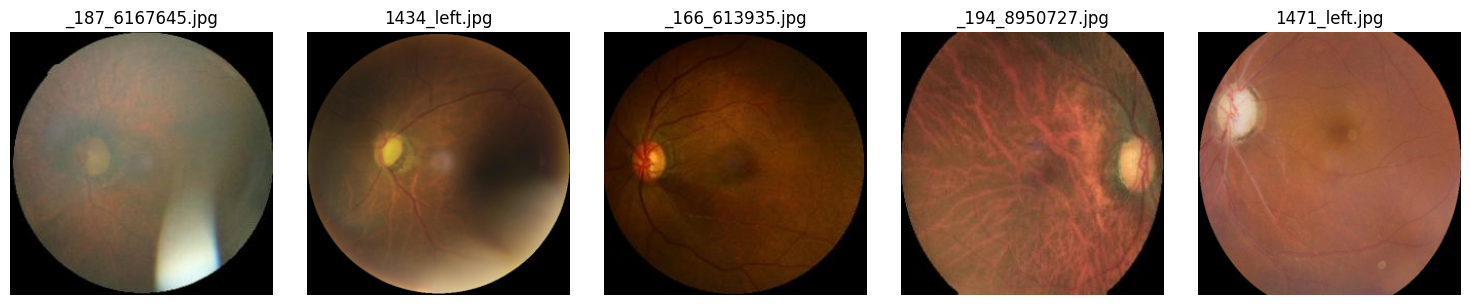

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/dataset/glaucoma"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

<a id="1"></a>
<div id="animated-container" style="position: relative;
            border-radius: 10px;
            padding: 10px;
            font-family: Arial, sans-serif;
            font-size: 36px;
            font-weight: 900;
            color: black;
            display: inline-block;
            text-transform: uppercase;
            box-shadow: 2px 2px 4px #888;
            text-shadow: 2px 2px 4px #888;
            overflow: hidden;
            background-color: #800606 ;
            cursor: pointer;" onclick="toggleAnimation()"> <!-- Added cursor pointer and onclick event -->
    <div style="position: absolute;
                top: 50%;
                right: 0; /* Adjusted to place on the right side */
                transform: translateY(45%);">
        <!-- <img src="https://www.kaggle.com/static/images/tier-animation-transparent.gif" alt="Cartoon Character" style="height: 100px; width: auto;"> -->
    </div>
    <div style="font-weight: bold;"></div>
    <span style="font-style: italic; text-shadow: 2px 2px 4px #888; color: white;">Normal 𓆩 👁️ 𓆪</span>
         <!-- <img src="https://pin.it/6mmgqwOvV" alt="Cartoon Character" style="height: 50px; width: auto;"> -->
</div>

<script>
    function toggleAnimation() {
        var container = document.getElementById('animated-container');
        var animationDiv = container.querySelector('div');
        if (animationDiv.style.animationPlayState === 'paused') {
            animationDiv.style.animationPlayState = 'running';
        } else {
            animationDiv.style.animationPlayState = 'paused';
        }
    }
</script>


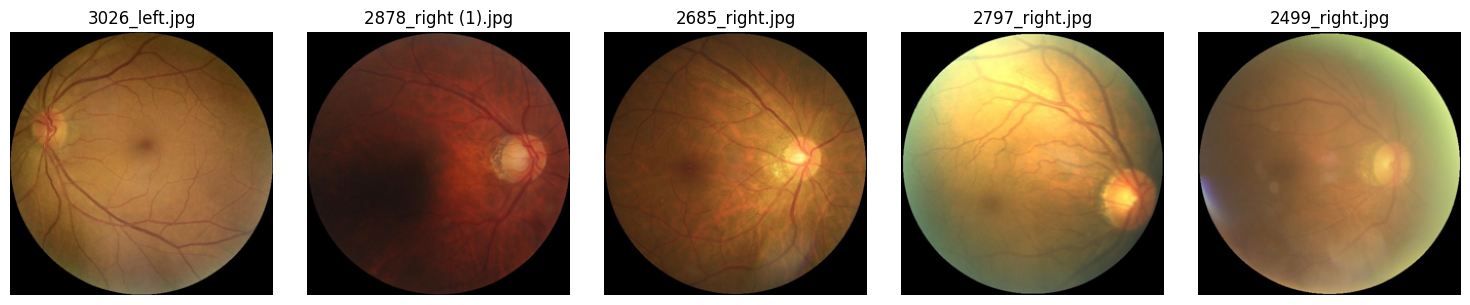

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/dataset/normal"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

<a id="1"></a>
<div id="animated-container" style="position: relative;
            border-radius: 10px;
            padding: 10px;
            font-family: Arial, sans-serif;
            font-size: 36px;
            font-weight: 900;
            color: black;
            display: inline-block;
            text-transform: uppercase;
            box-shadow: 2px 2px 4px #888;
            text-shadow: 2px 2px 4px #888;
            overflow: hidden;
            background-color: #800606 ;
            cursor: pointer;" onclick="toggleAnimation()"> <!-- Added cursor pointer and onclick event -->
    <div style="position: absolute;
                top: 50%;
                right: 0; /* Adjusted to place on the right side */
                transform: translateY(45%);">
        <!-- <img src="https://www.kaggle.com/static/images/tier-animation-transparent.gif" alt="Cartoon Character" style="height: 100px; width: auto;"> -->
    </div>
    <div style="font-weight: bold;"></div>
    <span style="font-style: italic; text-shadow: 2px 2px 4px #888; color: white;">Model 🤖</span>
         <!-- <img src="https://pin.it/6mmgqwOvV" alt="Cartoon Character" style="height: 50px; width: auto;"> -->
</div>

<script>
    function toggleAnimation() {
        var container = document.getElementById('animated-container');
        var animationDiv = container.querySelector('div');
        if (animationDiv.style.animationPlayState === 'paused') {
            animationDiv.style.animationPlayState = 'running';
        } else {
            animationDiv.style.animationPlayState = 'paused';
        }
    }
</script>


## **Build Model & Check Summary**

In [ ]:

# Define RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Reshape((64, 1)),  # Reshape for RNN input
    tf.keras.layers.SimpleRNN(32),  # Simple RNN layer
    tf.keras.layers.Dense(4, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,744,004 (14.28 MB)

 Trainable params: 3,744,004 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

None


## **Fit Model**

In [ ]:

# Define early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Fit the model with callbacks
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=5,
                    callbacks=[early_stopping])

Epoch 1/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 519s 5s/step - accuracy: 0.4801 - loss: 1.1126 - val_accuracy: 0.6047 - val_loss: 0.7988
Epoch 2/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 451s 4s/step - accuracy: 0.6789 - loss: 0.7130 - val_accuracy: 0.7439 - val_loss: 0.6069
Epoch 3/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 447s 4s/step - accuracy: 0.7273 - loss: 0.6162 - val_accuracy: 0.7392 - val_loss: 0.5958
Epoch 4/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 460s 4s/step - accuracy: 0.7509 - loss: 0.5704 - val_accuracy: 0.7532 - val_loss: 0.5850
Epoch 5/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 463s 4s/step - accuracy: 0.7745 - loss: 0.5243 - val_accuracy: 0.7064 - val_loss: 0.6567


## **Evaluate Model**

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy:", test_accuracy)

134/134 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.5925 - loss: 0.8683
Test accuracy: 0.7629179358482361


## **History Plot**

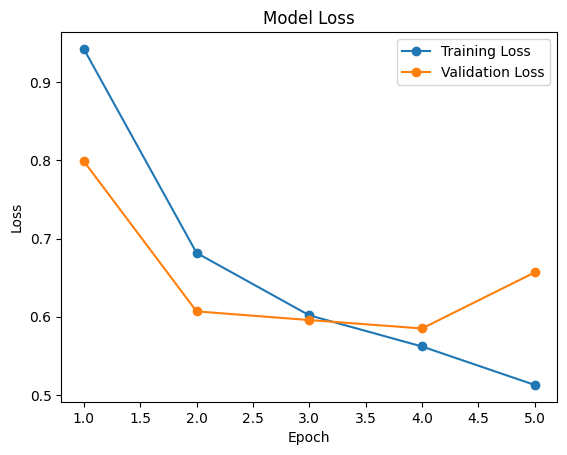

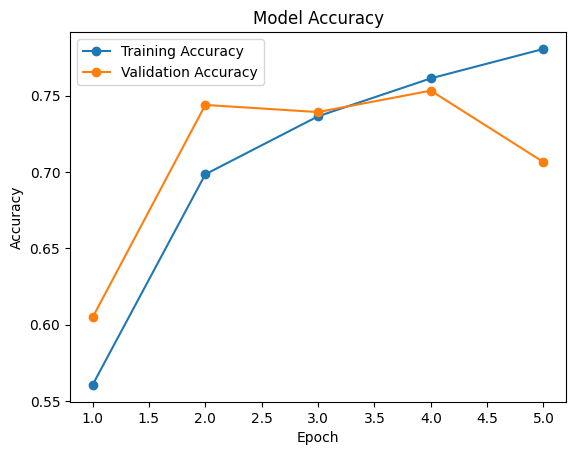

In [ ]:

# Define epochs
epochs = range(1, len(history.history['loss']) + 1)

# Plot training & validation loss
plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/saved_model.h5')
print("Model saved successfully as saved_model.h5")

Model saved successfully as saved_model.h5
